# Query GoogleMaps satellites tiles from given coordinates and zoom level

Some functions to retrieve GoogleMaps satellites tiles (that is to say 256x256 RGB images) from specified longitudes, latitudes and zoom levels.

Cyril Joly

In [1]:
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import requests
from PIL import Image


def url_to_numpy_array(url):
    response = requests.get(url)
    if response.status_code == 200:
        image = Image.open(BytesIO(response.content))
        image_array = np.array(image)
        return image_array
    else:
        raise Exception(f"Failed to download image. Status code: {response.status_code}")


def plot(x):
    plt.imshow(x)
    plt.axis('off')
    plt.gca().set_aspect('equal')
    plt.show()


def deg_to_rad(degrees):
    """Convert degrees to radians."""
    return degrees * (np.pi / 180)


def lon_lat_to_tile_coords(lon, lat, zoom):
    """Convert longitude and latitude in degrees to tile coordinates."""
    n = 2 ** zoom
    xtile = n * ((lon + 180) / 360)
    lat_rad = deg_to_rad(lat)
    ytile = n * (1 - (np.log(np.tan(lat_rad) + 1 / np.cos(lat_rad)) / np.pi)) / 2
    return np.floor(xtile).astype(int), np.floor(ytile).astype(int)


def get_url_tiles(zoom, xtile, ytile):
    return f'https://mt1.google.com/vt/lyrs=s&x={xtile}&y={ytile}&z={zoom}'


def get_url_coords(zoom, lon, lat):
    xtile, ytile = lon_lat_to_tile_coords(lon, lat, zoom)
    return get_url_tiles(zoom, xtile, ytile)

In [2]:
lon = -73.9857  # Example longitude
lat = 40.7484   # Example latitude
zoom = 8           # Example zoom level

get_url_coords(zoom=11, lon=2.333333, lat=48.866667)

'https://mt1.google.com/vt/lyrs=s&x=1037&y=704&z=11'

In [3]:
tile = url_to_numpy_array(get_url_coords(zoom=11, lon=2.333333, lat=48.866667))
tile.shape

(256, 256, 3)

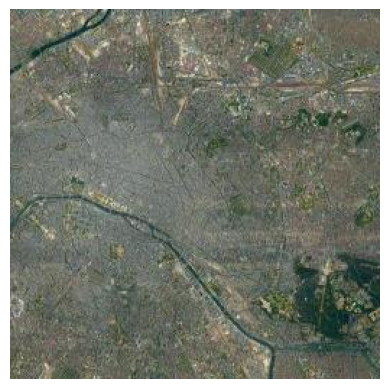

In [4]:
plot(url_to_numpy_array(get_url_coords(zoom=11, lon=2.333333, lat=48.866667)))

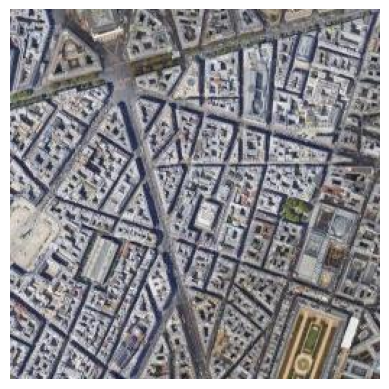

In [5]:
plot(url_to_numpy_array(get_url_coords(zoom=15, lon=2.333333, lat=48.866667)))

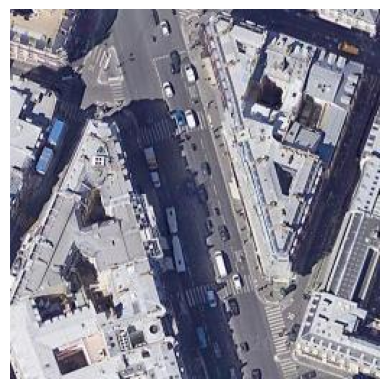

In [6]:
plot(url_to_numpy_array(get_url_coords(zoom=18, lon=2.333333, lat=48.866667)))